In [ ]:
import sys
path_to_pip_installs = "/tmp/test_env"
if path_to_pip_installs not in sys.path:
    sys.path.insert(0, path_to_pip_installs)

import os
import types
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as sk_psnr

from dataset_dixon import CreateDatasetSynthesis, CreateDatasetSynthesis_masks
from backbones.ncsnpp_generator_adagn_feat import NCSNpp, NCSNpp_adaptive
from backbones.dense_layer import conv2d  # not required here, but handy if you debug att maps
from train_utils import (
    get_time_schedule,
    q_sample_pairs,
    sample_posterior,
    sample_from_model,   # used for the "two-gens" path to stay 1:1 with training
    Diffusion_Coefficients,
    Posterior_Coefficients,
    _psnr_torch,
    parse_arguments,
)

# -------------------------
# Data loader
# -------------------------
def make_loader(args, phase="val", shuffle=False, input_path=None):
    """
    Build a DataLoader exactly like in training (DistributedSampler removed for notebook use).
    """
    if input_path is None:
        input_path = args.input_path
    ds = CreateDatasetSynthesis(phase=phase, input_path=input_path)
    loader = torch.utils.data.DataLoader(
        ds,
        batch_size=args.batch_size,
        shuffle=shuffle,
        num_workers=4,
        pin_memory=False,
        drop_last=False,
    )
    return loader

def make_loader_with_masks(args, phase="val", shuffle=False, input_path=None):
    """
    Build a DataLoader with masks exactly like in training (DistributedSampler removed for notebook use).
    """
    if input_path is None:
        input_path = args.input_path
    
    ds = CreateDatasetSynthesis_masks(phase=phase, input_path=input_path)
    loader = torch.utils.data.DataLoader(
        ds,
        batch_size=args.batch_size,
        shuffle=shuffle,
        num_workers=4,
        pin_memory=False,
        drop_last=False,
    )
    return loader

# -------------------------
# Model loading
# -------------------------
def _load_state_dict_strict(module, path, map_location):
    sd = torch.load(path, map_location=map_location)
    module.load_state_dict(sd)
    return module

def _load_state_dict_flex(module, src, map_location=None, strict=True):
    """
    Load a state_dict into `module`, handling DDP/DataParallel prefixes ("module.")
    and also accepting either a path or a dict.
    """
    if isinstance(src, str):
        state = torch.load(src, map_location=map_location)
    else:
        state = src

    # Some projects save under 'state_dict'
    if isinstance(state, dict) and 'state_dict' in state and all(
        isinstance(k, str) for k in state['state_dict'].keys()
    ):
        state = state['state_dict']

    try:
        module.load_state_dict(state, strict=strict)
        return
    except RuntimeError as e:
        # Try stripping "module." once
        if isinstance(state, dict) and any(k.startswith('module.') for k in state.keys()):
            stripped = {k.replace('module.', '', 1): v for k, v in state.items()}
            module.load_state_dict(stripped, strict=strict)
            return
        raise e

def load_models(args, ckpt_dir, epoch=None, map_location=None, load_g2=True):
    """
    Load gen_diffusive_1 (and optionally gen_diffusive_2) + sampling helpers.

    Parameters
    ----------
    args : Namespace
        Same args object you use for training (must include num_timesteps, nz, etc.).
    ckpt_dir : str
        Directory with saved checkpoints (e.g., exp_path).
    epoch : int or None
        If provided, loads gen_diffusive_1_{epoch}.pth and gen_diffusive_2_{epoch}.pth.
        If None, tries to load from 'content.pth'.
    map_location : device or str
        e.g., 'cuda:0' or 'cpu'. If None, auto-selects CUDA if available.
    load_g2 : bool
        If False, only loads gen_diffusive_1.

    Returns
    -------
    device, gen1, gen2_or_None, coeff, pos_coeff, T
    """
    if map_location is None:
        map_location = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    device = map_location if isinstance(map_location, torch.device) else torch.device(map_location)

    # Instantiate models exactly like train
    gen1 = NCSNpp(args).to(device).eval()
    gen2 = NCSNpp_adaptive(args).to(device).eval() if load_g2 else None

    # Load weights
    if epoch is not None:
        g1_path = os.path.join(ckpt_dir, f'gen_diffusive_1_{epoch}.pth')
        if not os.path.isfile(g1_path):
            raise FileNotFoundError(f"Missing {g1_path}")
        _load_state_dict_flex(gen1, g1_path, device)

        if load_g2:
            g2_path = os.path.join(ckpt_dir, f'gen_diffusive_2_{epoch}.pth')
            if not os.path.isfile(g2_path):
                raise FileNotFoundError(f"Missing {g2_path}")
            _load_state_dict_flex(gen2, g2_path, device)
    else:
        # fall back to content.pth (latest content snapshot from training)
        content_path = os.path.join(ckpt_dir, 'content.pth')
        if not os.path.isfile(content_path):
            raise FileNotFoundError(f"Provide epoch or ensure {content_path} exists.")
        content = torch.load(content_path, map_location=device)
        gen1.load_state_dict(content['gen_diffusive_1_dict'])
        if load_g2:
            gen2.load_state_dict(content['gen_diffusive_2_dict'])

    # Build sampling helpers exactly as in train
    coeff = Diffusion_Coefficients(args, device)
    pos_coeff = Posterior_Coefficients(args, device)
    T = get_time_schedule(args, device)

    # eval mode, no grads
    gen1.eval()
    if gen2 is not None:
        gen2.eval()
    torch.set_grad_enabled(False)

    return device, gen1, gen2, coeff, pos_coeff, T

# ----------------------------------------
# Predict with gen1 only (single-stage)
# ----------------------------------------
def _sample_from_model_g1_only(pos_coeff, gen1, cond1, cond2, cond3, num_steps, x_t, args):
    """
    Minimal faithful port of the inner loop you use in training:
    at each t, get x0_pred from gen1 and sample posterior to x_{t-1}.
    """
    device = x_t.device
    b = x_t.size(0)
    for i in reversed(range(num_steps)):
        t = torch.full((b,), i, device=device, dtype=torch.long)
        z = torch.randn(b, args.nz, device=device)
        x0_pred = gen1(x_t, cond1, cond2, cond3, t, z)              # shape [B, C(>=1), H, W], take channel 0 like train
        x_t = sample_posterior(pos_coeff, x0_pred[:, [0], :], x_t, t)
    return x_t

# ----------------------------------------
# Unified prediction function
# ----------------------------------------
def predict_sample(
    args,
    device,
    gen1,
    pos_coeff,
    T,
    *,
    gen2=None,
    cond1=None,
    cond2=None,
    cond3=None,
    num_timesteps=None,
    x_T=None,
    mode="both",         # "g1" or "both"
    seed=None,
):
    """
    Generate a sample using either only gen1 ("g1") or the two-stage path ("both")
    which calls your original sample_from_model.

    Inputs should be torch tensors already on `device` with shapes matching training:
      cond1, cond2, cond3: [B, 1, H, W] (or whatever your dataset returns)
    """
    assert mode in ("g1", "both"), "mode must be 'g1' or 'both'"

    if seed is not None:
        torch.manual_seed(seed)
        if device.type == "cuda":
            torch.cuda.manual_seed_all(seed)

    if num_timesteps is None:
        num_timesteps = args.num_timesteps

    # Make x_T if not given
    if x_T is None:
        # shape matches real_data from loader (use cond1’s shape for convenience)
        x_T = torch.randn_like(cond1)

    if mode == "both":
        if gen2 is None:
            raise ValueError("mode='both' requires gen2.")
        # Use the exact helper from training to ensure behavior parity
        out = sample_from_model(
            pos_coeff,
            gen1, cond1,
            gen2, cond2, cond3,
            num_timesteps,
            x_T, T, args
        )
        return out

    else:  # "g1"
        out = _sample_from_model_g1_only(
            pos_coeff,
            gen1,
            cond1, cond2, cond3,
            num_timesteps,
            x_T,
            args
        )
        return out

# ----------------------------------------
# Evaluation (exactly like validation loop)
# ----------------------------------------
def _to_range_0_1(x):
    return (x + 1.) / 2.

def eval_l1_psnr(fake, real, also_other_psnr=True):
    """
    Reproduces your validation metrics:
      - Convert to [0,1]
      - (a) divide-by-mean version
      - (b) without mean normalization
      - optional _psnr_torch just like the try/except in val loop

    Inputs: fake, real  (torch tensors, same shape)
    Returns dict of floats.
    """
    with torch.no_grad():
        fake_01 = _to_range_0_1(fake)
        real_01 = _to_range_0_1(real)

        # a) mean-normalized
        fake_div = fake_01 / fake_01.mean()
        real_div = real_01 / real_01.mean()

        fake_div_np = fake_div.detach().cpu().numpy()
        real_div_np = real_div.detach().cpu().numpy()
        l1_div = float(np.abs(fake_div_np - real_div_np).mean())
        psnr_div = float(sk_psnr(real_div_np, fake_div_np, data_range=real_div_np.max()))

        # b) without mean normalization
        fake_np = fake_01.detach().cpu().numpy()
        real_np = real_01.detach().cpu().numpy()
        l1_wmean = float(np.abs(fake_np - real_np).mean())
        psnr_wmean = float(sk_psnr(real_np, fake_np, data_range=real_np.max()))

        other_psnr = None
        if also_other_psnr:
            try:
                other_psnr = float(_psnr_torch(fake_01, real_01))
            except Exception:
                other_psnr = -1.0

    return {
        "l1_mean_norm": l1_div,
        "psnr_mean_norm": psnr_div,
        "l1_without_mean": l1_wmean,
        "psnr_without_mean": psnr_wmean,
        "psnr_other_fn": other_psnr,
    }

# ----------------------------------------
# Small convenience to fetch a single batch from a loader
# ----------------------------------------
def get_one_batch(loader, device):
    """
    Returns (cond1, cond2, cond3, gt) on device from the first batch.
    """
    batch = next(iter(loader))
    x1, x2, x3, x4 = batch
    return (
        x1.to(device, non_blocking=True),
        x2.to(device, non_blocking=True),
        x3.to(device, non_blocking=True),
        x4.to(device, non_blocking=True),
    )


def load_args_from_content(ckpt_dir, map_location='cpu'):
    """
    Load the saved args Namespace from a training content.pth file.

    Parameters
    ----------
    ckpt_dir : str
        Path to experiment directory (contains content.pth).
    map_location : str or torch.device
        Device for torch.load (args are just CPU objects, but safe to set).

    Returns
    -------
    args : argparse.Namespace
        The exact arguments object used during training.
    """
    content_path = os.path.join(ckpt_dir, "content.pth")
    if not os.path.isfile(content_path):
        raise FileNotFoundError(f"No content.pth in {ckpt_dir}")

    content = torch.load(content_path, map_location=map_location, weights_only=False)
    return content["args"]

# ===== Example usage in a notebook (adjust paths/args) =====
# args, _ = parse_arguments()    # or build your args Namespace manually for a notebook
# device, g1, g2, coeff, pos_coeff, T = load_models(args, ckpt_dir="/path/to/exp", epoch=100, load_g2=True)
# val_loader = make_loader(args, phase="val", shuffle=False)
# c1, c2, c3, gt = get_one_batch(val_loader, device)
#
# # --- two-stage prediction (same as training logs) ---
# x_T = torch.randn_like(gt)
# pred_both = predict_sample(args, device, g1, pos_coeff, T, gen2=g2, cond1=c1, cond2=c2, cond3=c3, x_T=x_T, mode="both")
# metrics_both = eval_l1_psnr(pred_both, gt)
#
# # --- gen1-only prediction ---
# x_T = torch.randn_like(gt)
# pred_g1 = predict_sample(args, device, g1, pos_coeff, T, gen2=None, cond1=c1, cond2=c2, cond3=c3, x_T=x_T, mode="g1")
# metrics_g1 = eval_l1_psnr(pred_g1, gt)
#
# print(metrics_both)
# print(metrics_g1)


In [13]:
args = load_args_from_content("results/exp_brats")
device, g1, g2, coeff, pos_coeff, T = load_models(args, ckpt_dir="results/exp_brats", epoch=20, load_g2=True)
val_loader = make_loader(args, phase="val", shuffle=False, input_path="data/my_data2")
train_loader = make_loader(args, phase="train", shuffle=False, input_path="data/my_data2")
test_loader = make_loader(args, phase="test", shuffle=False, input_path="data/my_data2")

padding in x-y with:0-0
padding in x-y with:0-0
padding in x-y with:0-0
padding in x-y with:0-0
padding in x-y with:0-0
padding in x-y with:0-0
padding in x-y with:0-0
padding in x-y with:0-0
padding in x-y with:0-0
padding in x-y with:0-0
padding in x-y with:0-0
padding in x-y with:0-0


In [14]:
val_loader_masks = make_loader_with_masks(args, phase="val", shuffle=False, input_path="data/my_data2")
train_loader_masks = make_loader_with_masks(args, phase="train", shuffle=False, input_path="data/my_data2")
test_loader_masks = make_loader_with_masks(args, phase="test", shuffle=False, input_path="data/my_data2")

padding in x-y with:0-0
padding in x-y with:0-0
padding in x-y with:0-0
padding in x-y with:0-0
padding in x-y with:0-0
padding in x-y with:0-0
padding in x-y with:0-0
padding in x-y with:0-0
padding in x-y with:0-0
padding in x-y with:0-0
padding in x-y with:0-0
padding in x-y with:0-0


In [ ]:
def predict_target(val_loader, index=0, mode="both"):
    c1,c2,c3,target = val_loader.dataset[index]
    c1 = c1.unsqueeze(0).to(device)
    c2 = c2.unsqueeze(0).to(device)
    c3 = c3.unsqueeze(0).to(device)
    target = target.unsqueeze(0).to(device)
    x_T = torch.randn_like(target)
    fake_target = predict_sample(args, device, g1, pos_coeff, T, gen2=g2, cond1=c1, cond2=c2, cond3=c3, x_T=x_T, mode="both")
    return fake_target

def visualize_prediction(val_loader, index=0, mode="both"):
    fake_target = predict_target(val_loader, index=index, mode=mode)
    c1,c2,c3,target = val_loader.dataset[index]
    c1 = c1.unsqueeze(0).to(device)
    c2 = c2.unsqueeze(0).to(device)
    c3 = c3.unsqueeze(0).to(device)
    target = target.unsqueeze(0).to(device)

    fig, axs = plt.subplots(1,3, figsize=(15,5))
    axs[0].imshow(c1[0,0,:,:].cpu(), cmap='gray')
    axs[0].set_title('BOLD')
    axs[1].imshow(c2[0,0,:,:].cpu(), cmap='gray')
    axs[1].set_title('Diffusion')
    axs[2].imshow(c3[0,0,:,:].cpu(), cmap='gray')
    axs[2].set_title('T1')
    for a in axs:
        a.axis('off')
    plt.show()

    fig, axs = plt.subplots(1,2, figsize=(10,5))
    axs[0].imshow(target[0,0,:,:].cpu(), cmap='gray')
    axs[0].set_title('target (ground truth)')
    axs[1].imshow(fake_target[0,0,:,:].cpu(), cmap='gray')
    axs[1].set_title(f'predicted target ({mode})')
    for a in axs:
        a.axis('off')
    plt.show()
    metrics_g1 = eval_l1_psnr(fake_target, target)
    print(metrics_g1)

import matplotlib.patches as mpatches
def visualize_prediction_with_masks(val_loader, val_loader_masks, index=0, mode="both"):
    # get images
    fake_target = predict_target(val_loader, index=index, mode=mode)
    c1,c2,c3,target = val_loader.dataset[index]
    c1 = c1.unsqueeze(0).to(device)
    c2 = c2.unsqueeze(0).to(device)
    c3 = c3.unsqueeze(0).to(device)
    target = target.unsqueeze(0).to(device)

    # get masks
    c1_mask,c2_mask,c3_mask,target_mask = val_loader_masks.dataset[index]
    c1_mask = c1_mask.unsqueeze(0).to(device)
    c2_mask = c2_mask.unsqueeze(0).to(device)
    c3_mask = c3_mask.unsqueeze(0).to(device)
    target_mask = target_mask.unsqueeze(0).to(device)

    fig, axs = plt.subplots(1,3, figsize=(15,5))
    axs[0].imshow(c1[0,0,:,:].cpu(), cmap='gray')
    axs[0].set_title('BOLD')
    axs[0].imshow(c1_mask[0,0,:,:].cpu(), cmap='gray', alpha=0.5)
    axs[1].imshow(c2[0,0,:,:].cpu(), cmap='gray')
    axs[1].set_title('Diffusion')
    axs[1].imshow(c2_mask[0,0,:,:].cpu(), cmap='gray', alpha=0.5)
    axs[2].imshow(c3[0,0,:,:].cpu(), cmap='gray')
    axs[2].set_title('T1')
    axs[2].imshow(c3_mask[0,0,:,:].cpu(), cmap='gray', alpha=0.5)
    for a in axs:
        a.axis('off')
    plt.show()

    fig, axs = plt.subplots(1,2, figsize=(10,5))
    axs[0].imshow(target[0,0,:,:].cpu(), cmap='gray')
    axs[0].set_title('target (ground truth)')
    axs[0].imshow(target_mask[0,0,:,:].cpu(), cmap='gray', alpha=0.5)
    axs[1].imshow(fake_target[0,0,:,:].cpu(), cmap='gray')
    axs[1].set_title(f'predicted target ({mode})')
    axs[1].imshow(c1_mask[0,0,:,:].cpu(), cmap='Reds', alpha=0.5)
    axs[1].imshow(c2_mask[0,0,:,:].cpu(), cmap='Greens', alpha=0.5)
    axs[1].imshow(c3_mask[0,0,:,:].cpu(), cmap='Blues', alpha=0.5)
    for a in axs:
        a.axis('off')

    # Create proxy patches for legend
    legend_patches = [
        mpatches.Patch(color='red', alpha=0.4, label='Mask C1'),
        mpatches.Patch(color='green', alpha=0.4, label='Mask C2'),
        mpatches.Patch(color='blue', alpha=0.4, label='Mask C3'),
    ]

    # Add legend to the second subplot
    axs[1].legend(handles=legend_patches, loc='upper right')
    plt.show()
    metrics_g1 = eval_l1_psnr(fake_target, target)
    print(metrics_g1)

    

## Validation set

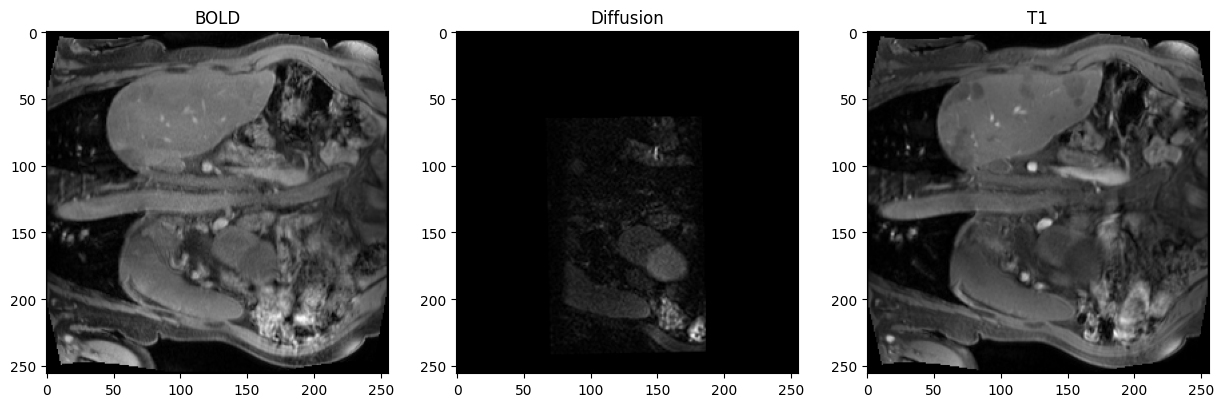

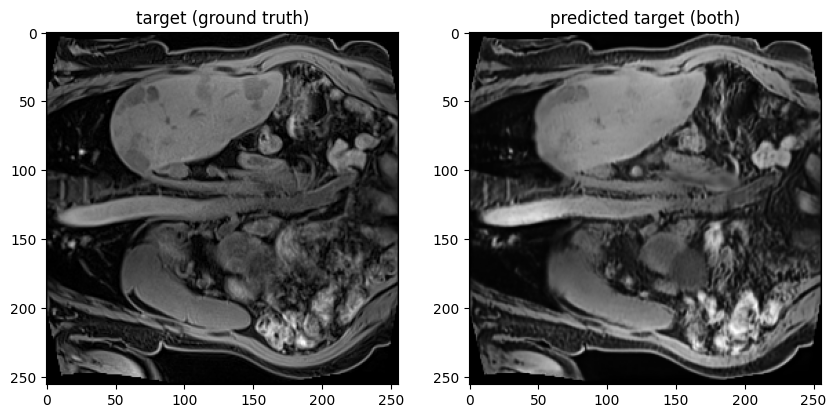

{'l1_mean_norm': 0.2731247544288635, 'psnr_mean_norm': 20.092420465897312, 'l1_without_mean': 0.059221282601356506, 'psnr_without_mean': 20.156557346581657, 'psnr_other_fn': 20.835257083009182}


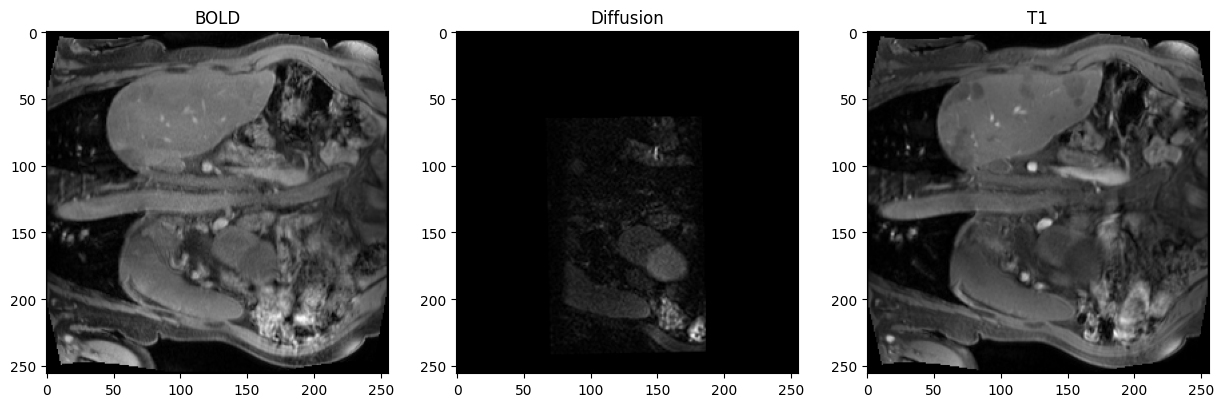

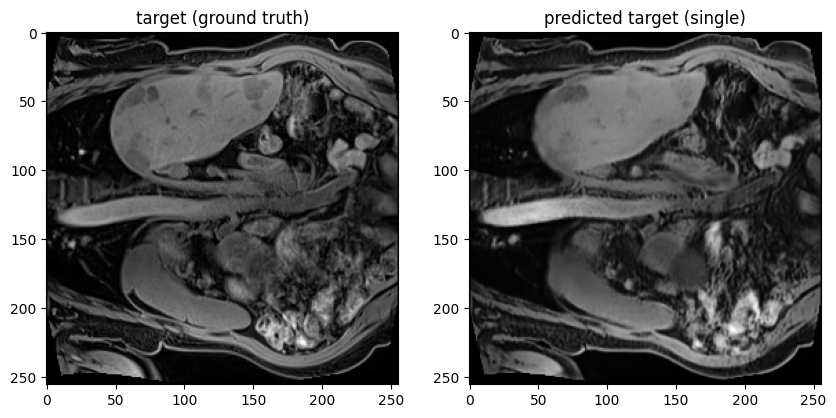

{'l1_mean_norm': 0.27752870321273804, 'psnr_mean_norm': 19.96940360464922, 'l1_without_mean': 0.058741554617881775, 'psnr_without_mean': 20.139968366677277, 'psnr_other_fn': 20.818668633976635}


In [11]:
visualize_prediction(val_loader, index=0, mode="both")
visualize_prediction(val_loader, index=0, mode="single")

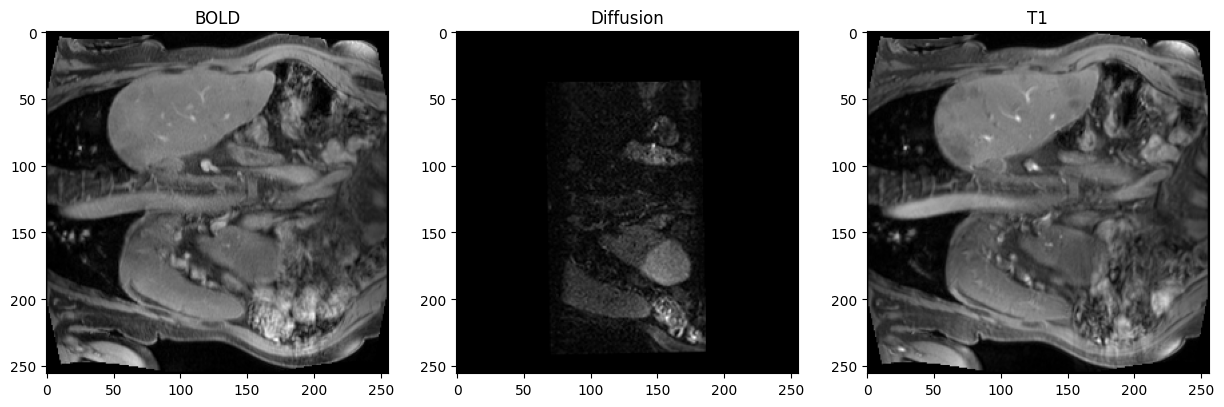

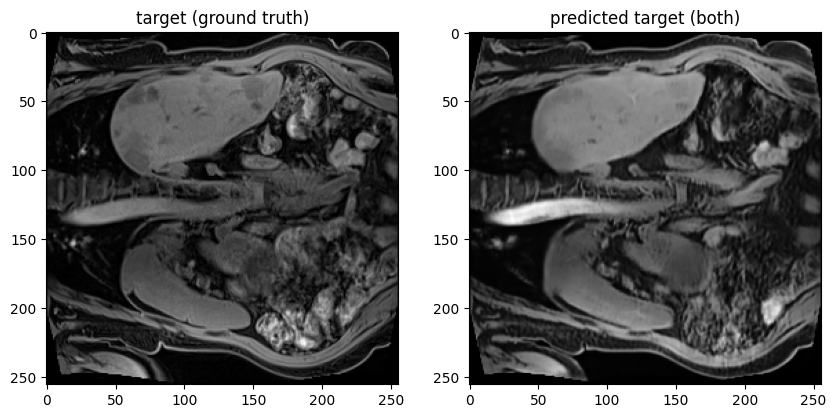

{'l1_mean_norm': 0.27668678760528564, 'psnr_mean_norm': 20.670876586747386, 'l1_without_mean': 0.05540154129266739, 'psnr_without_mean': 20.81113550723277, 'psnr_other_fn': 21.129124139638776}


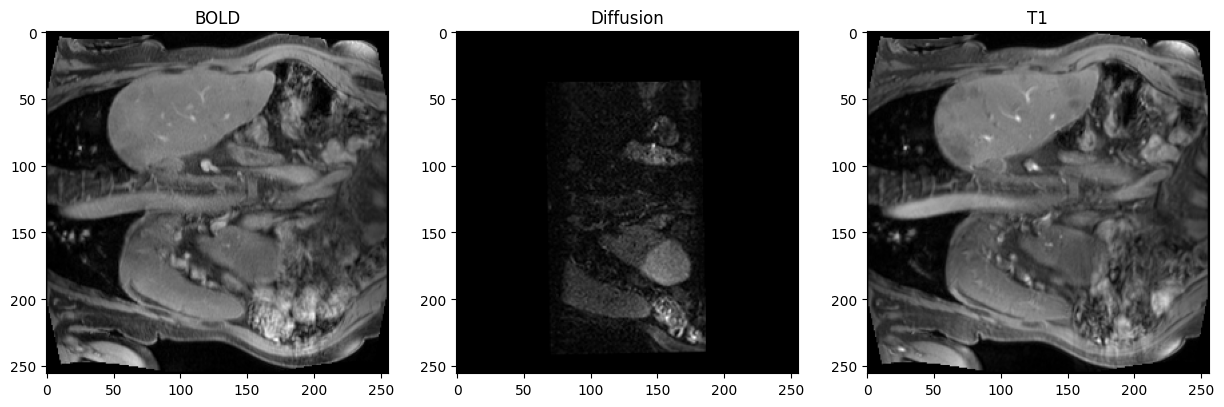

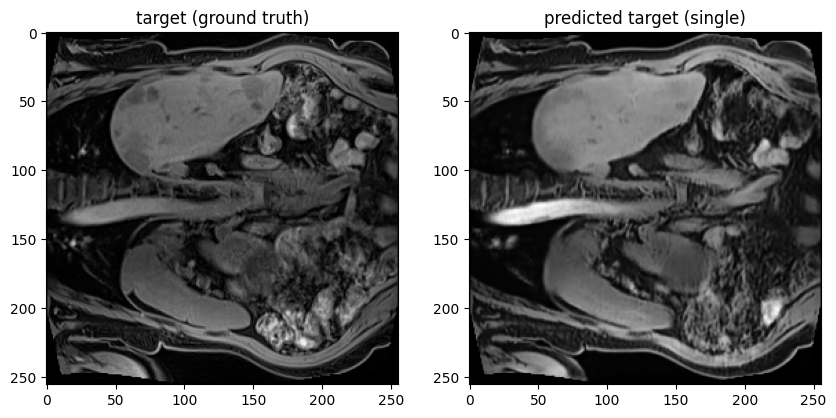

{'l1_mean_norm': 0.2792019248008728, 'psnr_mean_norm': 20.54533158861687, 'l1_without_mean': 0.055370792746543884, 'psnr_without_mean': 20.72330879975607, 'psnr_other_fn': 21.041297201168145}


In [59]:
visualize_prediction(val_loader, index=1, mode="both")
visualize_prediction(val_loader, index=1, mode="single")

## Test set

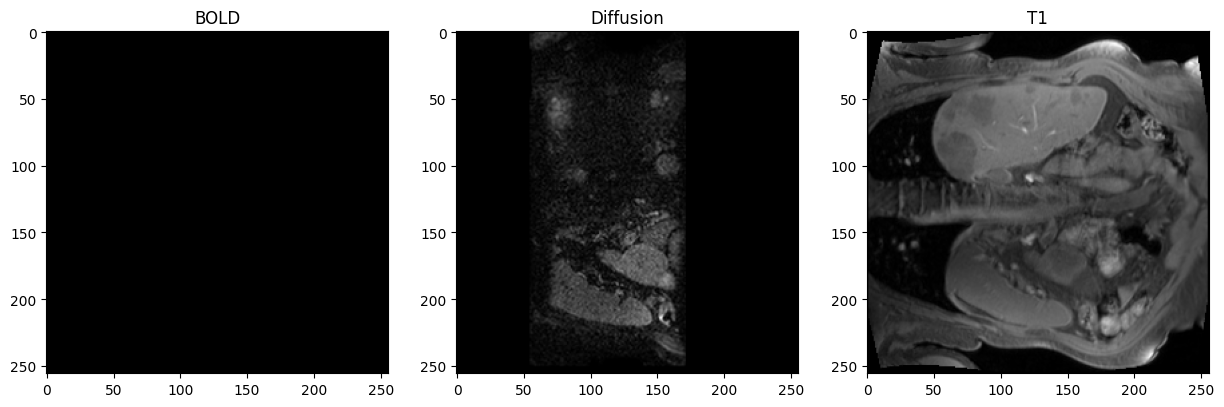

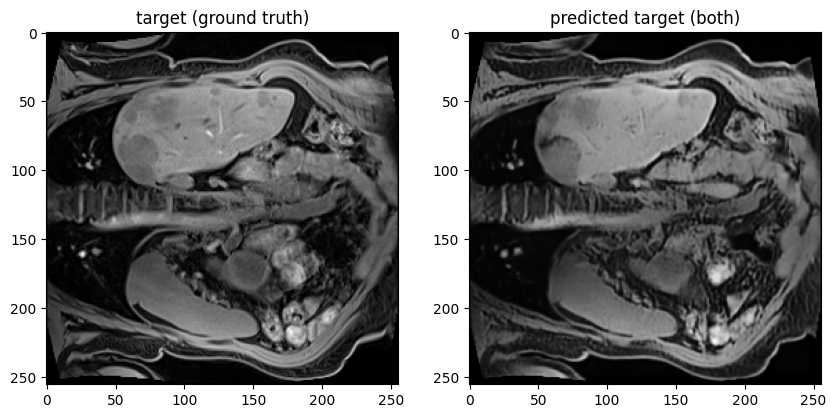

{'l1_mean_norm': 0.22394895553588867, 'psnr_mean_norm': 21.072580860075327, 'l1_without_mean': 0.06510430574417114, 'psnr_without_mean': 20.17926050023967, 'psnr_other_fn': 20.683845941499463}


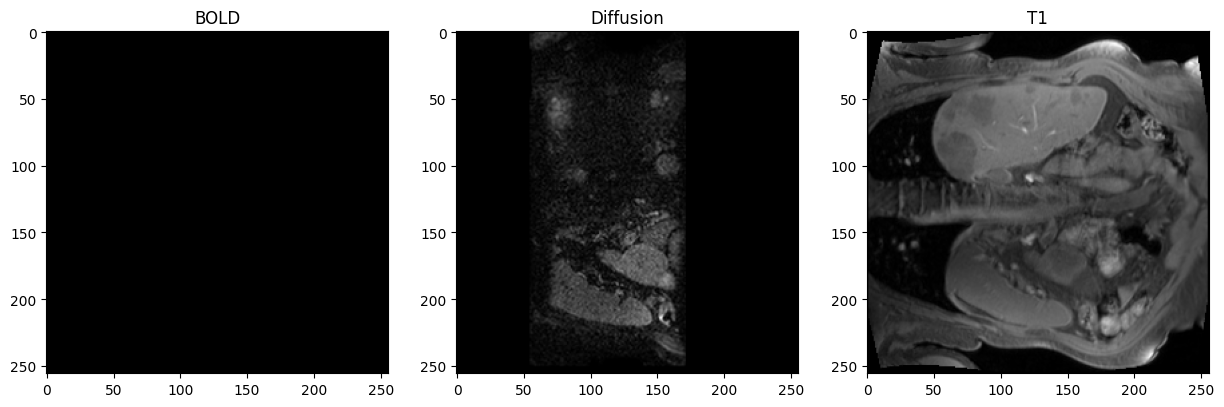

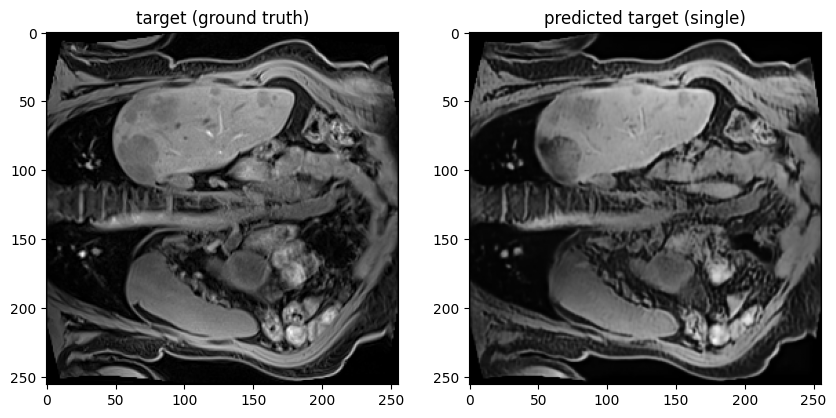

{'l1_mean_norm': 0.22834233939647675, 'psnr_mean_norm': 20.992194720749502, 'l1_without_mean': 0.0639144778251648, 'psnr_without_mean': 20.259519756980175, 'psnr_other_fn': 20.76410461879586}


In [60]:
visualize_prediction(test_loader, index=0, mode="both")
visualize_prediction(test_loader, index=0, mode="single")

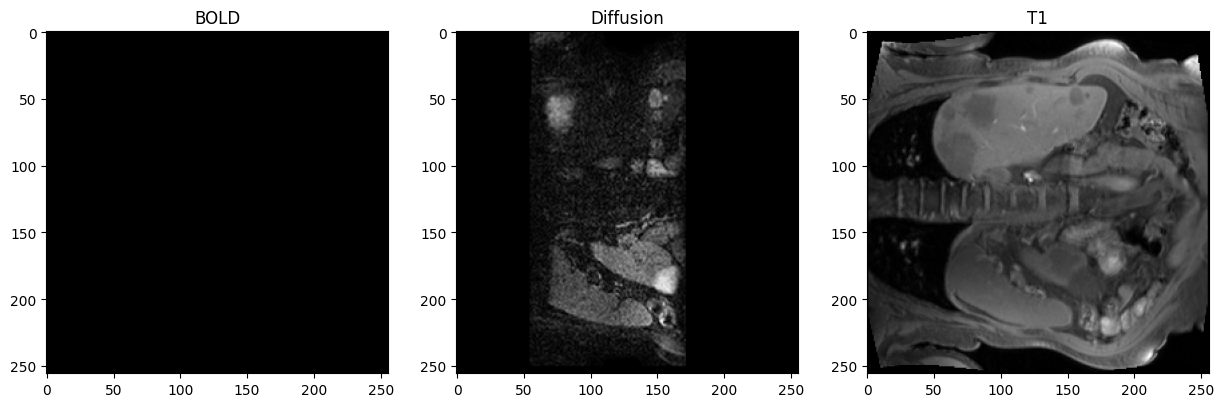

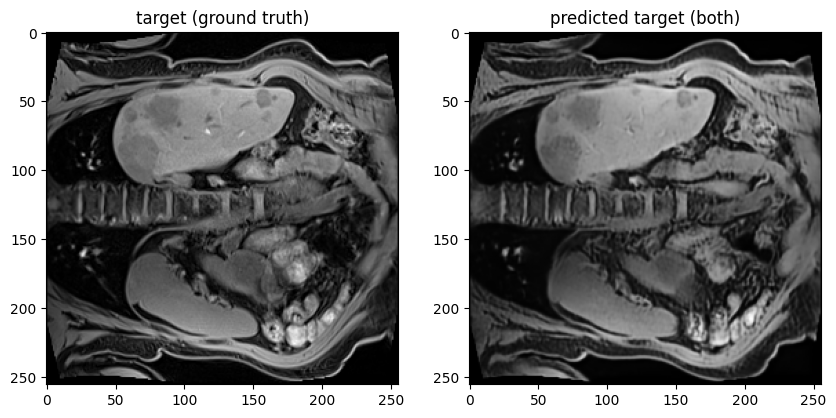

{'l1_mean_norm': 0.21633175015449524, 'psnr_mean_norm': 21.243566745220907, 'l1_without_mean': 0.06137009337544441, 'psnr_without_mean': 20.377337233317462, 'psnr_other_fn': 21.22973627272913}


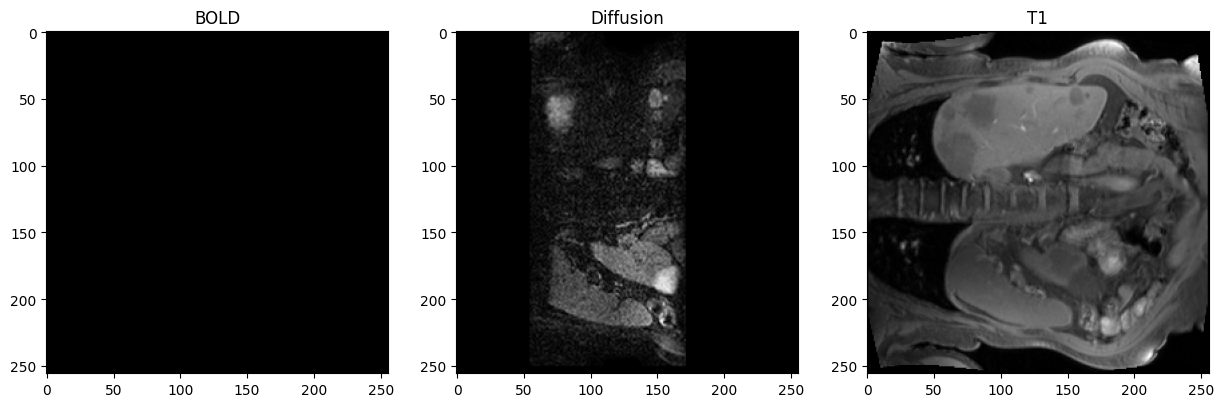

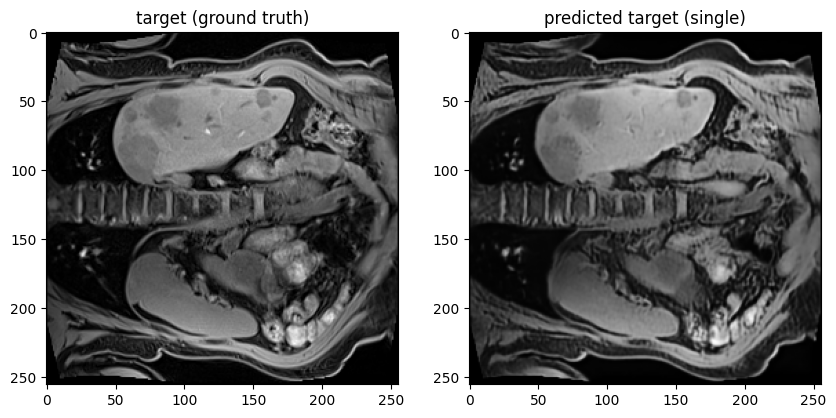

{'l1_mean_norm': 0.21584025025367737, 'psnr_mean_norm': 21.372639989259863, 'l1_without_mean': 0.05870768427848816, 'psnr_without_mean': 20.740389934912223, 'psnr_other_fn': 21.592788961220478}


In [61]:
visualize_prediction(test_loader, index=1, mode="both")
visualize_prediction(test_loader, index=1, mode="single")

## Visualize Masks

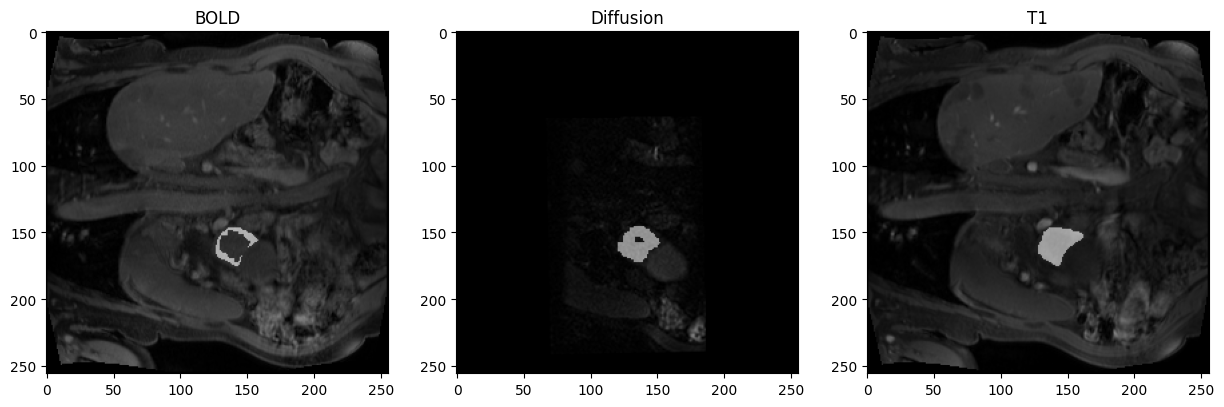

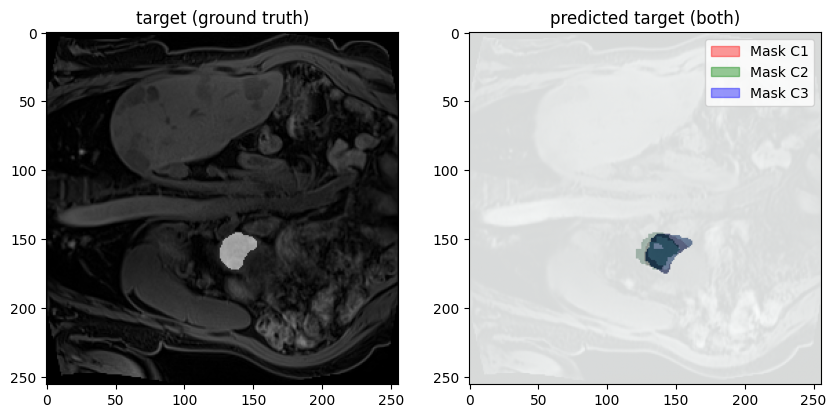

{'l1_mean_norm': 0.2737349569797516, 'psnr_mean_norm': 20.116961006895764, 'l1_without_mean': 0.05927487835288048, 'psnr_without_mean': 20.201332329479893, 'psnr_other_fn': 20.880032418059024}


In [18]:
visualize_prediction_with_masks(val_loader, val_loader_masks, index=0, mode="both")

## Create Predictions

In [ ]:
def save_prediction(image, save_path):
    """
    Save a predicted image in range [-1, 1] as uint8 [0, 255] PNG.
    Args:
        image (np.ndarray): Input image, values in [-1, 1].
        save_path (str): Path to save the PNG file.
    """
    # Ensure correct dtype and shape
    if not isinstance(image, np.ndarray):
        image = image.cpu().numpy()  # if it's a torch.Tensor

    # Clip just in case of numerical overshoot
    image = np.clip(image, -1, 1)

    # Convert [-1, 1] → [0, 255]
    image_uint8 = ((image + 1) / 2.0 * 255).astype(np.uint8)

    # Save as grayscale PNG
    cv2.imwrite(save_path, image_uint8)


def save_mask(mask, save_path):
    """
    Save a binary mask [0, 1] as uint8 [0, 255] PNG.
    Args:
        mask (np.ndarray): Binary mask, values in {0, 1}.
        save_path (str): Path to save the PNG file.
    """
    if not isinstance(mask, np.ndarray):
        mask = mask.cpu().numpy()  # if it's a torch.Tensor

    # Ensure binary 0/1
    mask = (mask > 0.5).astype(np.uint8)

    # Convert {0, 1} → {0, 255}
    mask_uint8 = mask * 255

    # Save as grayscale PNG
    cv2.imwrite(save_path, mask_uint8)


In [62]:
fake_target = predict_target(val_loader, index=0, mode="both")
c1,c2,c3,target = val_loader.dataset[0]
c1 = c1.unsqueeze(0).to(device)
c2 = c2.unsqueeze(0).to(device)
c3 = c3.unsqueeze(0).to(device)
target = target.unsqueeze(0).to(device)

In [19]:
c1.shape

NameError: name 'c1' is not defined

In [69]:
np.min(fake_target.numpy())

np.float32(-0.99998003)